# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

## VisCPU

In [1]:
from hera_sim.visibilities import VisCPU, HealVis#, VisGPU#, PRISim
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import itertools
import copy
from pyuvsim.analyticbeam import AnalyticBeam

import healvis as HEALVIS

%matplotlib inline
%load_ext autoreload
%autoreload 2

#### HEALVIS GIVES LONG WARNINGS
import warnings
warnings.filterwarnings("ignore")

In [39]:
### np.unique can reorder elements
def unique(arr):
    arr = np.array(arr)
    indices = np.unique(arr, return_index=True)[1]
    return np.array([arr.flatten()[i] for i in sorted(indices)])

def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16,8))
    
    fig.suptitle(type(simulator).__name__, fontweight='bold')
    
    #u_lsts = np.round(unique(simulator.uvdata.lst_array)*12/np.pi, 2)
    #step = len(u_lsts)/6
    
    #[axis.set_xticklabels(u_lsts[::step]) for axis in ax]
    
    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))
        #ax[0].plot(unique(simulator.uvdata.lst_array)*12/np.pi, 
        #   simulator.uvdata.data_array[auto_ind, 0, 0, 0], label="ant_{}".format(i))
        
        ax[0].plot(np.real(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), label="ant_{} real".format(i))
        ax[0].plot(np.imag(simulator.uvdata.data_array[auto_ind, 0, 0, 0]), linestyle="--", label="ant_{} imag".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j))
            #ax[1].plot(unique(simulator.uvdata.lst_array)*12/np.pi, simulator.uvdata.data_array[cross_ind, 0, 0, 0], label="bl({},{})".format(i,j))
            ax[1].plot(np.real(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), label="bl({},{}) real".format(i,j))
            ax[1].plot(np.imag(simulator.uvdata.data_array[cross_ind, 0, 0, 0]), linestyle="--", label="bl({},{}) imag".format(i,j))
            
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("Observation Number")
    #ax[1].set_xlabel("LST (hours)")

def compare_blts(simulator1, simulator2):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16, 8))
    
    name1 = type(simulator1).__name__
    name2 = type(simulator2).__name__
    
    fig.suptitle(name1 + " vs " + name2, fontweight='bold')
    
    lw=2

    for i in simulator1.uvdata.antenna_numbers:
        auto_ind = simulator1.uvdata.antpair2ind((i,i))
        
        ax[0].plot(np.real(simulator1.uvdata.data_array[auto_ind, 0, 0, 0]), label=("ant_{} " + name1).format(i), linewidth=lw)
        ax[0].plot(np.real(simulator2.uvdata.data_array[auto_ind, 0, 0, 0]), linestyle="--", label=("ant_{} "+name2).format(i), linewidth=lw)

        for j in simulator1.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator1.uvdata.antpair2ind((i,j))
            ax[1].plot(np.real(simulator1.uvdata.data_array[cross_ind, 0, 0, 0]), label=("bl({},{}) " + name1).format(i,j), linewidth=lw)
            ax[1].plot(np.real(simulator2.uvdata.data_array[cross_ind, 0, 0, 0]), linestyle="--", label=("bl({},{}) " + name2).format(i,j), linewidth=lw)
            
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("Observation Number")

``VisCPU`` natively deals with diffuse emission, and the ``VisibilitySimulator`` uses ``healpix`` maps to represent such emission:

In [3]:
def uniform_sky(nside_base=5, scale=1, nfreqs=5):
    NSIDE = 2**nside_base
    NPIX = 12 * NSIDE**2 # this is the number of pixels a healpix map has for  given NSIDE

    # Create a sky of purely ones, multiply by "scale"
    return scale * np.ones((nfreqs, NPIX))/NPIX

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [4]:
def myuvdata(ntimes=48, ntel=1, **kwargs):
    
    # Picking antenna postions in a deterministic way
    ants = {}
    for i in range(ntel):
        ants.update([(i, (-(i % 3), i, i % 4))])
    
    antpairs = list(set(itertools.permutations(ants.keys()*2, 2)))
      
    return io.empty_uvdata(
        nfreq = 5,
        time_per_integ = 86164.1/ntimes,
        ntimes= ntimes,
        ants = ants,
        antpairs = antpairs,
        **kwargs
    )

In [5]:
uvdata = myuvdata(ntel=2)
freqs = unique(uvdata.freq_array)

simulator = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=uniform_sky(5),
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

In [2]:
vis = simulator.simulate()
plot_blts(simulator)

NameError: name 'simulator' is not defined

Test whether increasing the number of pixels changes much

In [3]:
uvdata = myuvdata(ntel=2)
simulator = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

NameError: name 'myuvdata' is not defined

In [4]:
vis = simulator.simulate()
plot_blts(simulator)

NameError: name 'simulator' is not defined

### Point Sources

In [ ]:
uvdata1 = myuvdata(ntel=3, start_jd=2458119.5)
freqs = unique(uvdata1.freq_array)

point_source_pos1 = np.array([(0, uvdata1.telescope_lat_lon_alt[0])]) # ra, dec)
point_source_flx1 = np.array([[1.0]*len(freqs)]).T

uvdata2 = myuvdata(ntel=3, start_jd=2458119.0)
point_source_pos1 = np.array([(0, uvdata2.telescope_lat_lon_alt[0])]) # ra, dec)
point_source_flx1 = np.array([[1.0]*len(freqs)]).T


In [ ]:
simulator = VisCPU(
    uvdata = myuvdata(ntel=3, start_jd = 2458119.5,),
    point_source_pos=point_source_pos1,
    point_source_flux = point_source_flx1,
    sky_freqs = freqs,
)

simulator_jd = VisCPU(
    uvdata = myuvdata(ntel=3, start_jd = 2458119.0,),
    point_source_pos=point_source_pos1,
    point_source_flux = point_source_flx1,
    sky_freqs = freqs,
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

vis_jd = simulator_jd.simulate()
plot_blts(simulator_jd)

In [ ]:
print "Eq2Top for .5: ", simulator.get_eq2tops()[:, 0, 0]
print "Eq2Top for .0: ", simulator_jd.get_eq2tops()[:, 0, 0]


In [ ]:
print np.unique(simulator.uvdata.lst_array)
print np.unique(simulator_jd.uvdata.lst_array)

In [ ]:
simulator.uvdata.lst_array

In [ ]:
simulator.get_eq2tops()

In [ ]:
point_source_pos = np.array([ # ra, dec
    (0, myuvdata().telescope_lat_lon_alt[0]),
    (0.1, myuvdata().telescope_lat_lon_alt[0])
]) 
point_source_flx = np.array([[1.0, 1.0]]*len(freqs))

In [ ]:
simulator = VisCPU(
    uvdata = myuvdata(),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flx,
    sky_freqs = freqs,
)

In [ ]:
vis = simulator.simulate()
print np.max(np.abs(vis-simulator.uvdata.data_array))


plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. The beam can be set as a series of healpix maps, one for each antenna. 
An extra list of ``beam_ids`` specifies which of the beams each antenna uses. So, we can create something like a Gaussian beam:

In [ ]:
simulator = VisCPU(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(6),
    sky_freqs = freqs,
    beams = [AnalyticBeam("gaussian", diameter=14)]
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

## HealVis

We could also have used healvis for this:

In [ ]:
simulator = HealVis(
    uvdata = myuvdata(ntel=3),
    sky_freqs = freqs,
    sky_intensity = 100*uniform_sky(6),
)

In [ ]:
vis = simulator.simulate()

In [ ]:
plot_blts(simulator)
fig = plt.gcf()

In [ ]:
simulator = HealVis(
    uvdata = myuvdata(ntimes=12, ntel=3),
    point_source_pos=point_source_pos,
    point_source_flux = point_source_flux,
    sky_freqs = freqs,
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

## Comparing VisCPU & HealVis

### Airy Beams

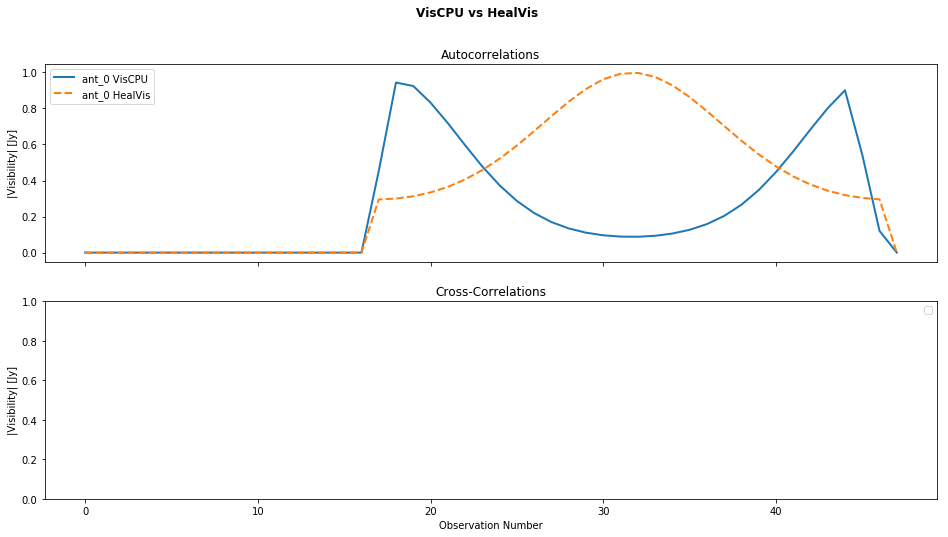

In [40]:
uvdata = myuvdata(ntel=1, ntimes=48)
uvdata1 = myuvdata(ntel=1, ntimes=48)
freqs = unique(uvdata.freq_array)

point_source_pos = np.array([[0, uvdata.telescope_lat_lon_alt[0]]])
point_source_flux = np.array([[1.0]] * len(freqs))

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2**4,
    beams = [AnalyticBeam("airy", diameter=2)],
    real_dtype=np.float64,
    complex_dtype=np.complex128,
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    beams = [AnalyticBeam("airy", diameter=2)],
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

#plot_blts(viscpu_sim)
#plot_blts(healvis_sim)

compare_blts(viscpu_sim, healvis_sim)

In [ ]:
uvdata = myuvdata()
uvdata1 = myuvdata()
freqs = unique(uvdata.freq_array)

viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

print "MAX ABSOLUTE DIFF", np.max(np.abs(viscpu-healvis))

plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure()

### 2 Telescope Uniform Sky

In [14]:
uvdata = myuvdata(ntel=2)
uvdata1 = myuvdata(ntel=2)

freqs = np.unique(uvdata.freq_array)

viscpu_sim = VisCPU(
    uvdata=myuvdata(ntel=3),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=myuvdata(ntel=3),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

print "MAX ABSOLUTE DIFF", np.max(np.abs(np.real(viscpu)-np.real(healvis)))

plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure()


print unique(healvis_sim.uvdata.lst_array)*12/np.pi
print np.unique(healvis_sim.uvdata.lst_array)*12/np.pi

ValueError: Error code returned by bispev: 10

In [ ]:
print healvis_sim.uvdata.antpair2ind((0,0))
print healvis_sim.uvdata.antpair2ind((0,1))
print healvis_sim.uvdata.antpair2ind((1,0))
print healvis_sim.uvdata.antpair2ind((1,1))
print healvis_sim.uvdata.data_array.shape

### ??? 2 Telescope Hemispherical Source ???

In [ ]:
sky_intensity = uniform_sky(6)
sky_intensity[:,:sky_intensity.shape[1]/2] = 0.0
print sky_intensity

uvdata = myuvdata(ntel=2)
uvdata1 = myuvdata(ntel=2)

freqs = np.unique(uvdata.freq_array)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=sky_intensity,
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    sky_intensity=sky_intensity,
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

print "MAX ABSOLUTE DIFF", np.max(np.abs(np.real(viscpu)-np.real(healvis)))

plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure()

### 2 Telescope Point Source at Zenith

MAX ABSOLUTE DIFF 1.9884522


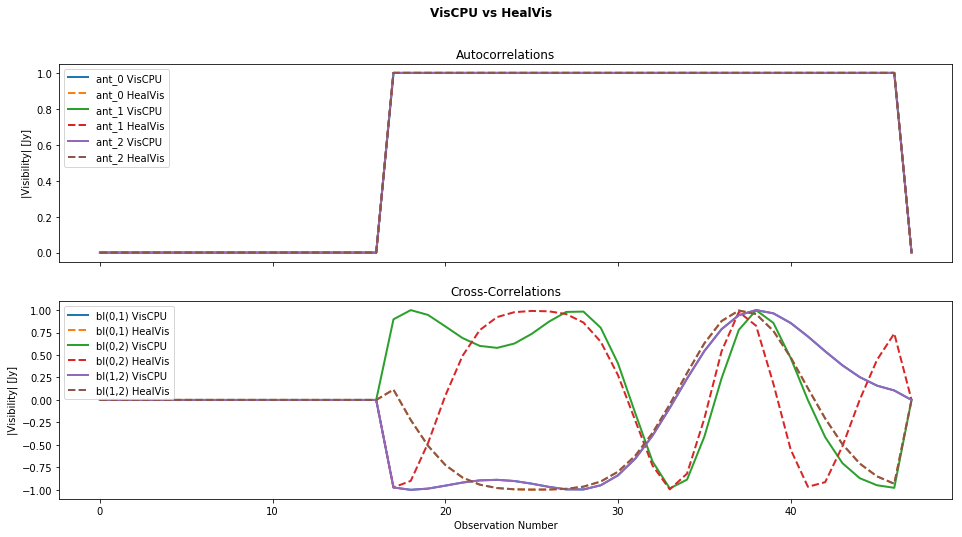

In [42]:
uvdata = myuvdata(ntel=3)
uvdata1 = myuvdata(ntel=3)
freqs = np.unique(uvdata.freq_array)

point_source_pos = np.array([[0, uvdata.telescope_lat_lon_alt[0]]])
point_source_flux = np.array([[1.0]] * len(freqs))

viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128,
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2 ** 4
)

viscpu_sim.simulate()
healvis_sim.simulate()

viscpu = viscpu_sim.uvdata.data_array
healvis = healvis_sim.uvdata.data_array

print "MAX ABSOLUTE DIFF", np.max(np.abs(viscpu-healvis))

#plot_blts(viscpu_sim)
#plot_blts(healvis_sim)

compare_blts(viscpu_sim, healvis_sim)

In [ ]:
### Using Cross-Correlations of pair (0, 1)
def print_across_freq(simulator):
    freqs = unique(simulator.uvdata.freq_array)
    fig, ax = plt.subplots(len(freqs), 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"})
    for i in range(len(freqs)):
        f = freqs[i]
        indices = simulator.uvdata.antpair2ind(0,1)
        ax[i].plot(np.real(simulator.uvdata.data_array[indices, 0, i, 0]), label="freq {} real".format(i))
        ax[i].plot(np.imag(simulator.uvdata.data_array[indices, 0, i, 0]), label="freq {} imag".format(i), linestyle="--")
            
    ax[0].legend()
    ax[-1].legend()
    ax[0].set_title("Cross-Correlations")
    ax[-1].set_xlabel("Observation Number")

                   
plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure()
print_across_freq(viscpu_sim)
print_across_freq(healvis_sim)


In [ ]:
a = [ [["time 1 ant 11", "time 1 ant12"], ["time 1 ant 21", "time 1 ant22"]], [["time 2 ant 11", "time 2 ant12"], ["time 2 ant 21", "time 2 ant22"]], [["time 3 ant 11", "time 3 ant12"], ["time 3 ant 21", "time 3 ant22"]] ] 
a= np.array(a)

b =  a.flatten()
print b[1]

### 2 Telescope 2 Point Sources

MAX ABSOLUTE DIFF 2.4124262034171213


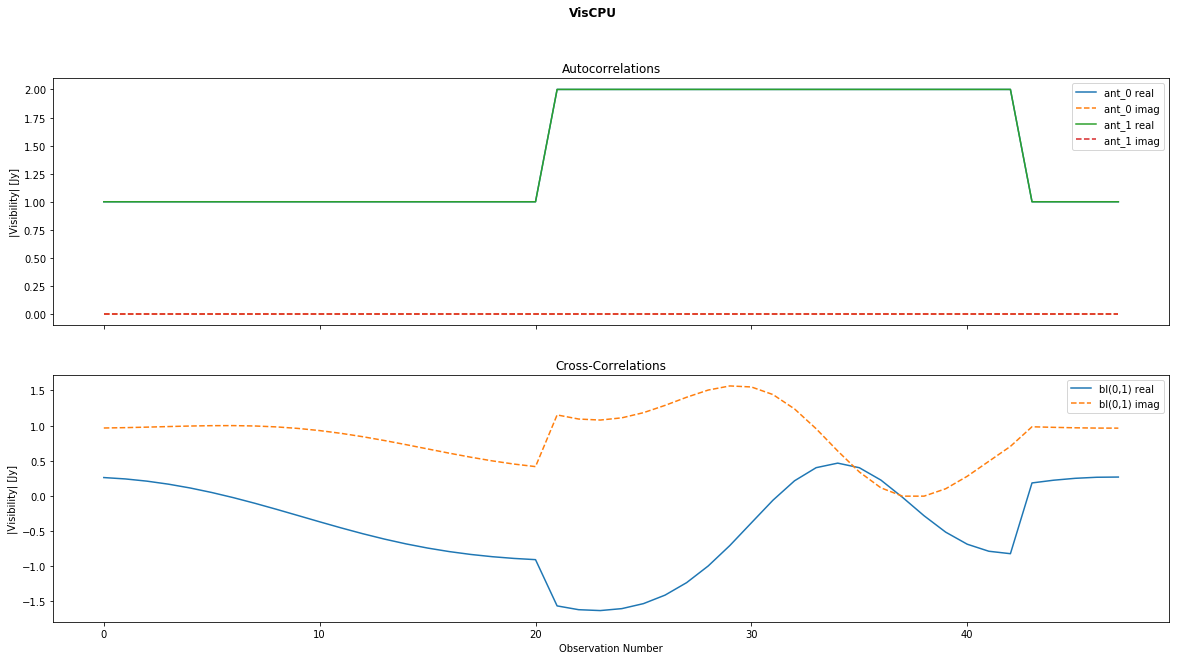

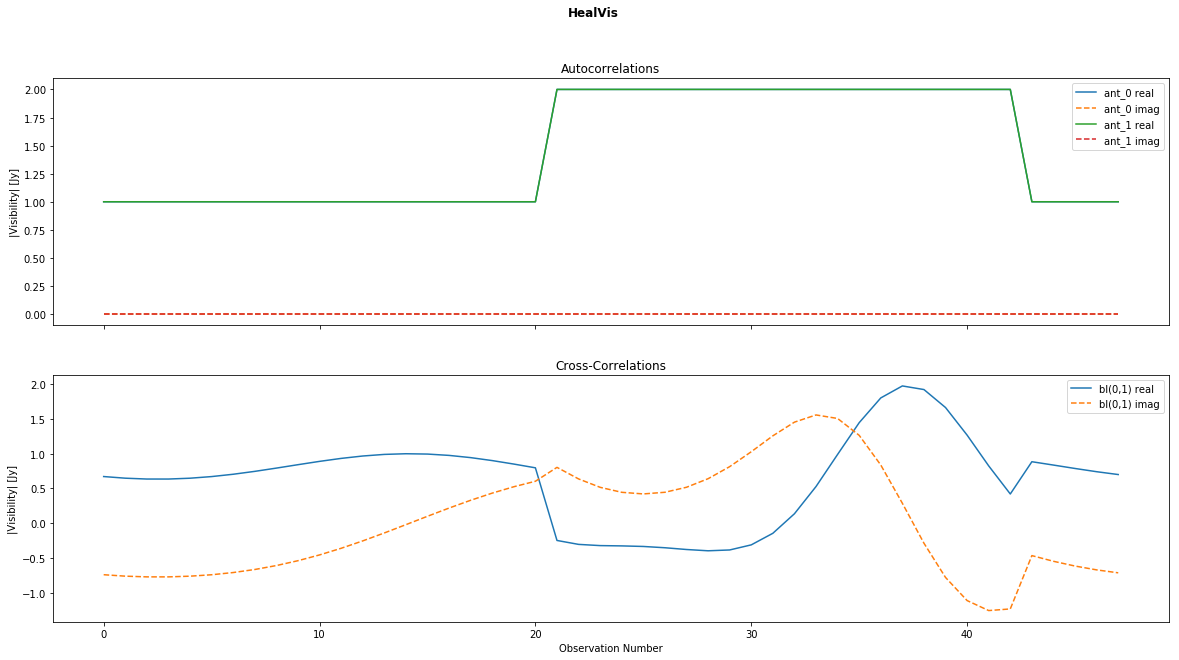

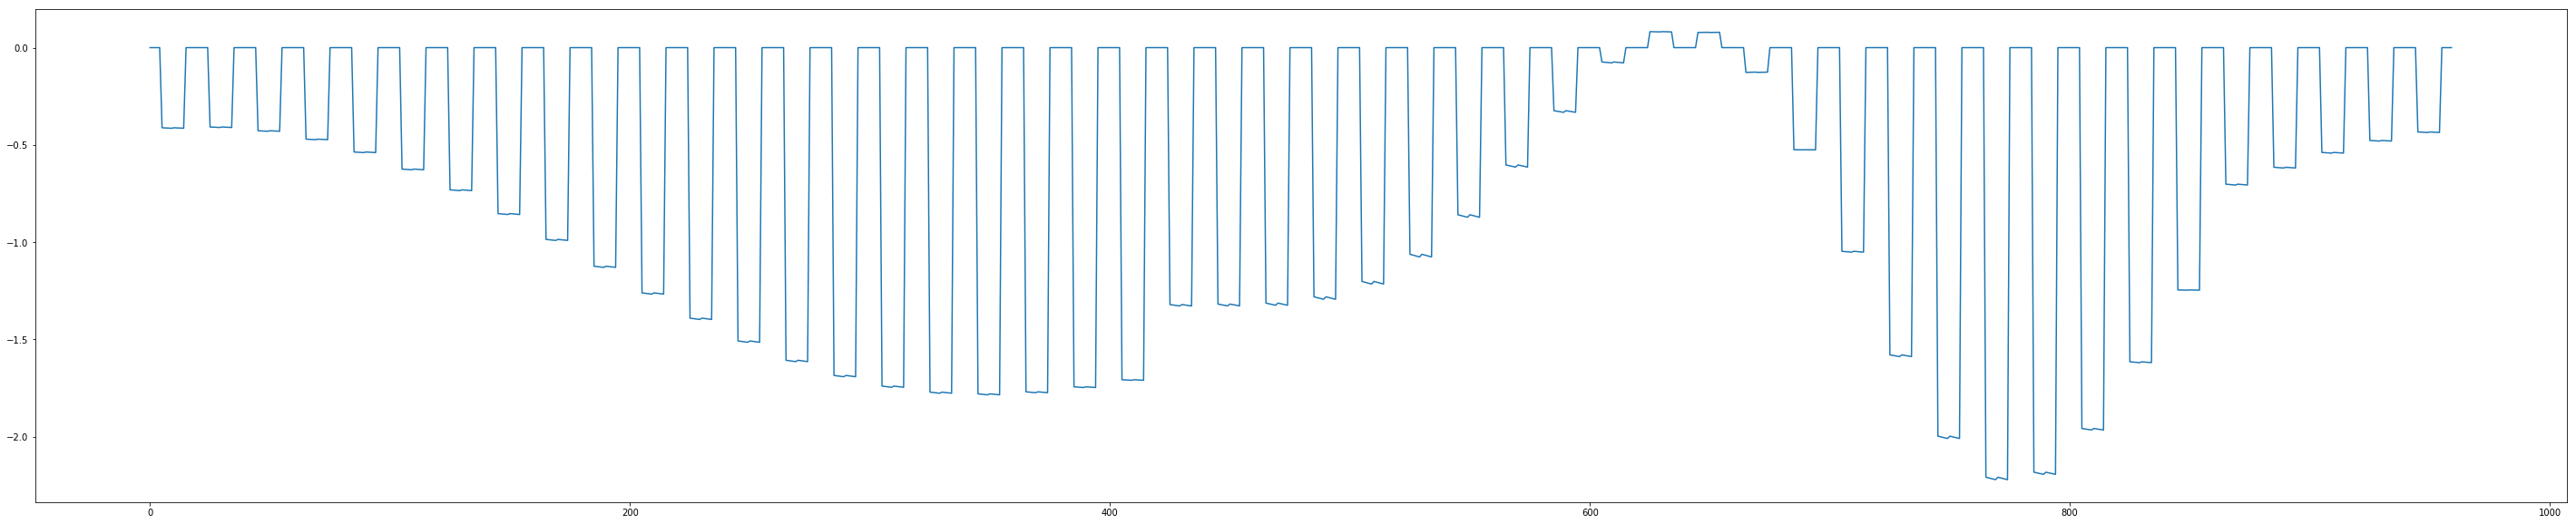

In [9]:
uvdata = myuvdata(ntel=2)
uvdata1 = myuvdata(ntel=2)
freqs = unique(uvdata.freq_array)
point_source_pos = np.array([[0, uvdata.telescope_lat_lon_alt[0] - np.pi/4], [0, uvdata.telescope_lat_lon_alt[0] + np.pi/4]])
point_source_flux = np.array([[1.0, 1.0]] * len(freqs))

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=point_source_pos,
    point_source_flux=point_source_flux,
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()

print "MAX ABSOLUTE DIFF", np.max(np.abs(viscpu-healvis))

plot_blts(viscpu_sim)
plot_blts(healvis_sim)
plt.figure(figsize=(50,10))
plt.plot(viscpu.flatten() - healvis.flatten())

### Point Sources

In [ ]:
# put a point source in
point_source_pos = np.array([[0, uvdata2().telescope_lat_lon_alt[0] + np.pi/4]])
point_source_flux = np.array([[1.0]] * len(freqs))

viscpu_sim = VisCPU(
    uvdata=uvdata2(),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2**4,
    real_dtype=np.float64,
    complex_dtype=np.complex128, 
)

healvis_sim = HealVis(
    uvdata=uvdata2(),
    sky_freqs=freqs,
    sky_intensity=uniform_sky(6),
    nside=2 ** 4
)

viscpu = viscpu_sim.simulate()
healvis6 = healvis_sim.simulate()

In [ ]:
np.max(np.abs(healvis6-heal_copy))

In [ ]:
plot_blts(viscpu_sim)
plot_blts(healvis_sim)

## PRISim

In [ ]:
simulator = PRISim(
    uvdata = myuvdata(),
    sky_intensity = uniform_sky(5),
    sky_freqs = freqs,
)

In [ ]:
vis = simulator.simulate()
plot_blts(simulator)

In [ ]:
uv = myuvdata()

In [ ]:
uv.tel